In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import pickle
import warnings
warnings.filterwarnings('ignore')
# For NLP operations such as tokenization, lemmatization, and stopword removal
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import requests
from bs4 import BeautifulSoup
import functools
import operator

pd.set_option('display.max_colwidth', 4000)


# Data Cleaning and Preprocessing

In [2]:
def clean_routes(routes, drop_unrated = True):
    cleaned_routes = routes.drop_duplicates()
    
    if drop_unrated:
        cleaned_routes = cleaned_routes[~cleaned_routes.star_ratings.isnull()]
        cleaned_routes = cleaned_routes[cleaned_routes['star_ratings'] != '{}']
        
    cleaned_routes['description'] = cleaned_routes['description'].fillna('')
    cleaned_routes['id'] = cleaned_routes['id'].astype(int)
    cleaned_routes = cleaned_routes.rename(columns = {'id' : 'route_id', 'name' : 'route_name'})
    cleaned_routes['area_id'] = cleaned_routes['area_id'].astype(int)
    cleaned_routes['pitches'] = cleaned_routes['pitches'].astype(int)
    cleaned_routes['votes'] = cleaned_routes['votes'].astype(int)
    cleaned_routes['route_name'] = cleaned_routes['route_name'].fillna('Unnamed')
    cleaned_routes['height'] = cleaned_routes['height'].map(lambda x: 'Unspecified' if x == 0 else x)
    # dictionary of user ratings is saved as a string, convert to a python dict
    cleaned_routes['star_ratings'] = cleaned_routes['star_ratings'].map(lambda x: ast.literal_eval(x))
    boulder_grades = pd.read_csv('./data/boulder_grades.csv')
    climb_grades = pd.read_csv('./data/climb_grades.csv')
    
    
    grade_dict = {v:k for k,v in boulder_grades.to_dict()['grade'].items()}
    grade_dict.update({v:k for k,v in climb_grades.to_dict()['grade'].items()})


    
    cleaned_routes = cleaned_routes[~cleaned_routes['grade'].isin(['5.?', 'V?', ''])]
    cleaned_routes = cleaned_routes[cleaned_routes['grade'].isin(grade_dict.keys())]
    
    cleaned_routes = cleaned_routes[cleaned_routes['pitches'] != 80]
    cleaned_routes['grade_numeric'] = cleaned_routes['grade'].map(grade_dict).astype(int)
    return cleaned_routes

def clean_area(areas):
    cleaned_areas = areas.drop_duplicates()
    
    cleaned_areas['parent_id'] = cleaned_areas['parent_id'].fillna(0)
    cleaned_areas['parent_id'] = cleaned_areas['parent_id'].astype(int)
    cleaned_areas = cleaned_areas.rename(columns = {'id' : 'area_id', 'name' : 'area_name'})
    return cleaned_areas

In [3]:
# this is a list of words to be removed 
# consists of all stopwords, and stopwords with punctuation (apostrophes) removed as these show up often
remove_words = list(set(stopwords.words('english') +  \
                        [x.replace("'", "") for x in stopwords.words('english')]))


tokenizer = RegexpTokenizer(r"\w+")

# tokenize text and remove stopwords and any
def clean_text(text):
    text_tokens = tokenizer.tokenize(text)
    return ' '.join([word for word in text_tokens if ((word not in remove_words) & (word.isalpha()))])


def process_descriptions(df):
    
    df = df.copy()
    
    # convert to lowercase
    df['description_original'] = df['description'].copy()
    df['description'] = df['description'].str.lower()

    
    
    # First remove html converted symbols and hyperlinks from title and selftext
    df['description'] = df['description'].str.replace(r'&\w*;', '')

    df['description'] = df['description'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True)\
                 .replace('#\S+', '', regex=True).replace('\n\n\S+', '', regex=True)
    
    
    # apply stopword/symbol remover
    df['description'] = df['description'].map(clean_text)
    
    # remove digits
    df['description'] = df['description'].str.replace(r'\d+', '')

    return df
    

In [4]:
def get_ratings(routes):
    ratings = []
    for i,row in routes.iterrows():
        for user, stars in row['star_ratings'].items():
            ratings.append({'user_id': user, 'route_id' : row['route_id'], 'user_rating' : stars})

    ratings = pd.DataFrame(ratings)
    
    return pd.merge(ratings, routes, left_on = 'route_id', right_on='route_id').drop(columns = 'star_ratings')

In [5]:
class MPAreaTree:
    def __init__(self, areas = None):
        if(areas is not None):
            self.build(areas)            
        else:
            self.area_dict = {}
            self.areas = areas.copy()
            
    def build(self, areas):
        self.area_dict = {}
        self.areas = areas.copy()
        for i,row in areas.iterrows():
            self.area_dict[row['area_id']] = {'area_name' : row.area_name, 'parent' : row.parent_id, 'children' : []}
        for i,row in areas.iterrows():
            if row["parent_id"] != 0:
                self.area_dict[row["parent_id"]]['children'].append(row["area_id"])
                
    def get_name(self, area_id):
        return self.areas[self.areas['area_id'] == area_id]['area_name'].unique()[0]

    def get_parent_chain(self, area_id):
        chain = []
        current_id = area_id
        while current_id != 0:
            chain = [(self.get_name(current_id), current_id)] + chain
            current_id = self.area_dict[current_id]['parent']
        return chain
    def get_children(self, area_id):
        
        return [area_id] + functools.reduce(operator.iconcat, [self.get_children(child) for child in self.area_dict[area_id]['children']], [])
    def get_parent_chain_names(self, area_id):
        chain = get_parent_chain(area_id)
        return [self.get_name(x) for x in chain] 
    
    def get_height(self,area_id):
        if len(self.area_dict[area_id]['children']) == 0:
            return 0
        else:
            return 1 + max([self.get_height(child) for child in self.area_dict[area_id]['children']]) 

    def get_formatted_name(self, area_id):
        if self.area_dict[area_id]['parent'] == 0:
            return self.area_dict[area_id]['area_name']
        return self.get_formatted_name(self.area_dict[area_id]['parent']) + ' > ' + self.area_dict[area_id]['area_name']
    
    
    def get_depth(self,area_id):
        return len(self.get_parent_chain(area_id))-1
    
    

In [6]:
import os 

def load_states(states):
    routes = []
    areas = []
    for state in states:
        if os.path.exists(f'./data/{state}_routes.csv') and os.path.exists(f'./data/{state}_areas.csv'):
            print(f'Found route/area data for {state}.')
            r = clean_routes(pd.read_csv(f'./data/{state}_routes.csv'))

            a = clean_area(pd.read_csv(f'./data/{state}_areas.csv'))

            r['state'] = state
            a['state'] = state
            r = r.merge(a[['area_id', 'area_name']], left_on = 'area_id', right_on = 'area_id')
            routes.append(r)
            areas.append(a)

    routes = pd.concat(routes).reset_index(drop = True)
    areas = pd.concat(areas).reset_index(drop = True)
    
    return routes, areas

In [7]:
state_names = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", 
               "Delaware", "Florida", "Georgia",  "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas",
               "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", 
               "Mississippi", "Montana", "North Carolina",  "North Dakota", "Nebraska", "New Hampshire", 
               "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", 
               "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", 
               "Tennessee", "Texas", "Utah", "Virginia",  "Vermont", 
               "Washington", "Wisconsin", "West Virginia", "Wyoming"]
routes, areas = load_states(state_names)

Found route/area data for Alabama.
Found route/area data for Arkansas.
Found route/area data for Colorado.
Found route/area data for Delaware.
Found route/area data for Florida.
Found route/area data for Georgia.
Found route/area data for Hawaii.
Found route/area data for Iowa.
Found route/area data for Illinois.
Found route/area data for Indiana.
Found route/area data for Kansas.
Found route/area data for Kentucky.
Found route/area data for Louisiana.
Found route/area data for Maryland.
Found route/area data for Maine.
Found route/area data for Michigan.
Found route/area data for Minnesota.
Found route/area data for Missouri.
Found route/area data for Mississippi.
Found route/area data for North Dakota.
Found route/area data for Nebraska.
Found route/area data for New Hampshire.
Found route/area data for New Jersey.
Found route/area data for Ohio.
Found route/area data for Oklahoma.
Found route/area data for Oregon.
Found route/area data for Rhode Island.
Found route/area data for Sou

In [8]:
routes['state'].unique().shape

(32,)

In [9]:
area_tree = MPAreaTree(areas)

In [10]:
areas.shape

(17000, 7)

In [11]:
routes.shape

(75211, 14)

In [12]:
ratings = get_ratings(routes)

In [13]:
ratings.shape

(1171869, 15)

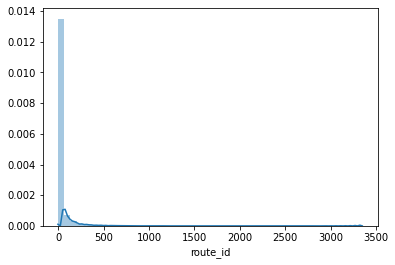

In [35]:
sns.distplot(ratings.groupby('user_id')['route_id'].count())

Text(0.5, 0, 'Number of User Ratings')

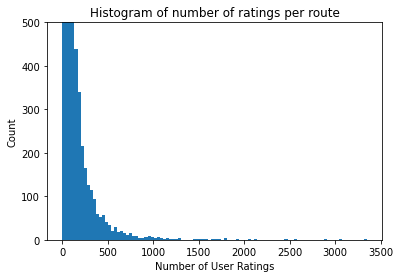

In [97]:
ratings.groupby('user_id')['route_id'].count().hist(bins = 100, grid = False)
plt.ylim([0,500])
plt.title('Histogram of number of ratings per route')
plt.ylabel('Count')
plt.xlabel('Number of User Ratings')

Text(0.5, 0, 'Unique Routes Rated')

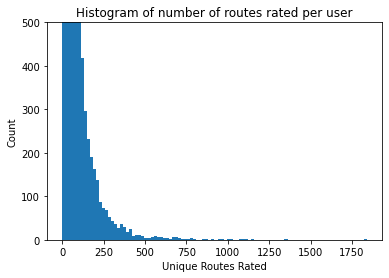

In [93]:
ratings.groupby('route_id')['user_id'].count().hist(bins = 100, grid = False)
plt.ylim([0,500])
plt.title('Histogram of number of routes rated per user')
plt.ylabel('Count')
plt.xlabel('Unique Routes Rated')

In [28]:
len(ratings['user_id'].unique())

39367

Text(0.5, 1.0, 'Number of Climbs by State')

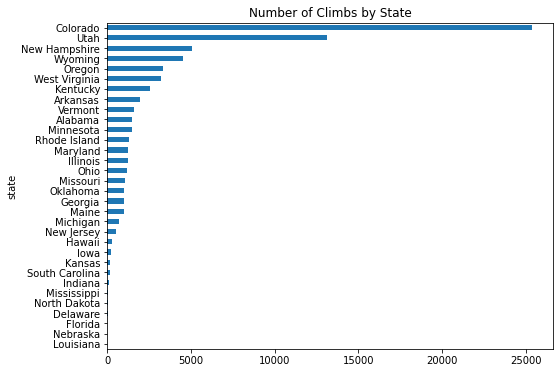

In [26]:
plt.figure(figsize = (8,6))
routes.groupby('state')['score'].count().sort_values(ascending = True).plot.barh()
plt.title('Number of Climbs by State')

In [57]:
routes.drop(columns = ['description', 'star_ratings']).sort_values('votes', ascending = False)[['route_name','type', 'pitches','score','votes','state']].head(10).set_index('route_name')

,type,pitches,score,votes,state
route_name,,,,,
The Bastille Crack,Trad,5,3.5,1842,Colorado
Rewritten,Trad,6,3.7,1346,Colorado
Incredible Hand Crack,Trad,1,3.8,1147,Utah
5 Gallon Buckets,Sport,1,3.2,1117,Oregon
Supercrack of the Desert,Trad,3,3.8,1097,Utah
Direct Route,Trad,10,3.5,1081,Colorado
The Yellow Spur,Trad,6,3.8,1031,Colorado
Wind Ridge,Trad,4,3.1,1004,Colorado
Calypso,Trad,3,3.0,959,Colorado


,route_id,user_id,route_name,type,area_id,grade,height,pitches,score,votes,description,star_ratings,grade_numeric,state,area_name
0,105748490,1839,The Bastille Crack,Trad,105744723,5.7,350,5,3.5,1842,"One of the most classic climbs in the country, it begins right off the road on the Bastille, a 350' cliff on the left as you enter the canyon. Often crowded, a weekday is probably the best time to attempt this climb. The climb is north facing and in the shade until mid-afternoon. As Jim Erickson said in his classic 1980 Rocky Heights guidebook, ""avoid it like the plague if the weather is not warm, or you will shiver away much of its charm."" Start at the center of the north face of the Bastille, below a hand crack that starts 20' up the wall, with a huge, serrated flake to its right. The first pitch has been the site of numerous accidents, so make sure you're solid on 5.7 crack climbing and placing pro before attempting to lead it. P1. 5.7, 60'. Climb up to the flake and step left to the crack. Jam or layback up the polished crack (crux), then follow the crack up and left to a small stance at a 2-bolt anchor with chains. You can belay here (if you want to watch/coach your second through the crux), or continue with the second pitch. P2. 5.6, 90'. Climb up to the chimney left of the bolts, and step left onto the face. Climb up to a finger crack, then traverse right above a little roof (crux). Continue up steep, enjoyable cracks and angle up left on easy ground to a sloping ledge by a steep wall. Belay at a crack with a fixed pin. If this belay is occupied, it's possible to belay about 20' lower at another stance. Variation: near the top of P2, take a right-angling wide crack up and back left, 5.8. Bring a big cam (#4 Camalot) to protect this line. P1 & P2 can be combined with a 50m rope. P3. 5.7, 50'. Climb up into a pod, then work up past a small roof (crux). Continue up the cracks to another sloping ledge. A #1 and #2 Camalot are useful for the belay anchor. P1-3 can be combined with a 70m rope. P4. 5.6, 100'. Traverse left to a short corner with a destroyed fixed pin. Continue traversing left on awkward, off-balance moves past another fixed pin (crux). Go all the way left to a hand crack and climb it to a corner. Don't start up too soon or you'll be off route on a harder variation. Climb the corner, then continue up and right on easy ramps to a belay stance below or just right of a chimney. P5. Several options here: a. Easy finish: 5.4, 60'. Climb the chimney to the top. b. Fun finish: 5.8, 80'. Climb up a ramp right of the chimney to a huge corner with a wide crack. Climb up the face left of the corner to a fixed pin. Continue up the steep headwall and surmount a little roof at the top (crux). If you have a #3 and #4 Camalot, you can belay just above the roof (and watch/coach your second at the crux roof), otherwise continue up an easy gully and belay from a spike of rock at the top. c. Grovel finish: 5.7, 80'. Climb the wide crack in the corner just right of the previous variation. To descend: follow deep grooves to the south until you reach a dirt trail. Go 30' right (west) and then follow the marked Bastille descent trail north and down to the road at the base of the cliff. (Ed. Note: beginner leaders--make sure you're solid on crack techique before trying this one. Placing gear is not trivial for the inexperienced.)","{105867487: 4, 106733454: 4, 10106: 4, 106692255: 4, 107066303: 4, 106740073: 4, 105787381: 4, 14185: 4, 14233: 4, 10114: 4, 11613: 4, 10520: 4, 106502223: 4, 106367966: 4, 11327: 4, 14209: 4, 105787407: 4, 105788780: 4, 106098377: 4, 106079202: 4, 105787249: 4, 11711: 4, 105793180: 4, 11466: 4, 106235451: 4, 10168: 4, 12407: 4, 105804873: 4, 106670905: 4, 107212777: 4, 105792600: 4, 105815478: 4, 13782: 4, 106945872: 4, 11916: 4, 106985478: 4, 14213: 4, 107521029: 4, 105790905: 4, 10762: 4, 106733673: 4, 105790750: 4, 107005232: 4, 106034624: 4, 106737176: 4, 105084823: 4, 107568252: 4, 12494: 4, 12448: 4, 1

In [22]:
routes.groupby('state')['score'].mean().sort_values(ascending = True)

state
Nebraska          1.750000
Rhode Island      2.131811
New Jersey        2.165278
Mississippi       2.224000
Delaware          2.248276
New Hampshire     2.276436
Colorado          2.283199
Kansas            2.307182
Michigan          2.360055
Maryland          2.373169
Hawaii            2.405882
Oklahoma          2.420437
Minnesota         2.430488
Vermont           2.434837
Missouri          2.436022
Utah              2.454886
North Dakota      2.463830
Indiana           2.487736
Arkansas          2.504466
Georgia           2.519556
Ohio              2.530954
Alabama           2.532568
South Carolina    2.552174
West Virginia     2.588259
Oregon            2.598898
Illinois          2.603312
Wyoming           2.604683
Kentucky          2.609094
Maine             2.633266
Iowa              2.680478
Florida           2.896000
Louisiana         3.333333
Name: score, dtype: float64

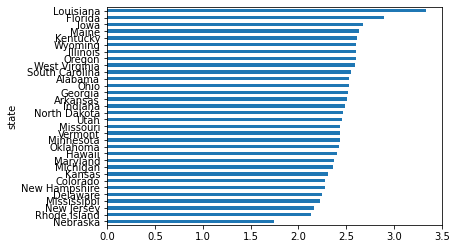

In [21]:

routes.groupby('state')['score'].mean().sort_values(ascending = True).plot.barh()

In [14]:
ratings['user_id'].unique().shape

(39367,)

In [15]:
routes.to_csv('./data/routes.csv', index = False)
areas.to_csv('./data/areas.csv', index = False)
ratings.to_csv('./data/ratings.csv', index = False)

In [16]:
pickle.dump(area_tree, open('./pickle/area_tree.pkl', 'wb'))

In [ ]:
routes['score'].mean()

In [ ]:
routes['votes'].mean()

In [ ]:
ratings['user_rating'].mean()

In [ ]:
ratings.groupby('user_id').count().mean()

In [ ]:
sns.regplot(data = routes, x = 'score', y = 'votes')

Text(0, 0.5, '')

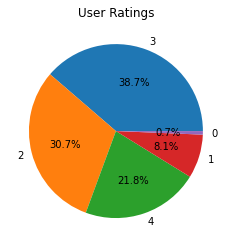

In [152]:
ratings['user_rating'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('User Ratings')
plt.ylabel('')

Text(0.5, 1.0, 'Star Rating Counts')

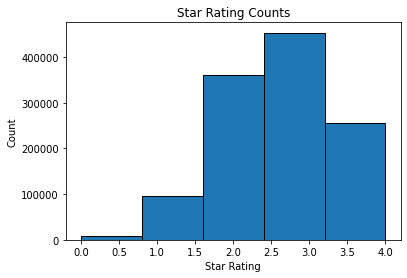

In [60]:
#myarray = ratings['user_rating']
#weights = np.ones_like(myarray)/float(len(myarray))
#plt.hist(myarray, weights=weights, edgecolor = 'black')
ratings['user_rating'].hist(bins = 5, grid=False,edgecolor = 'black', density = False)

plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Star Rating Counts')

In [ ]:
ratings.groupby('user_id').count()

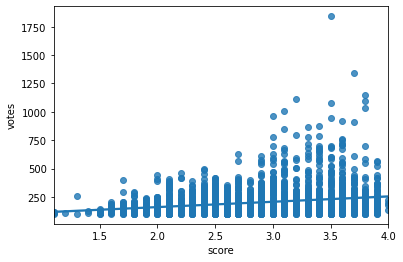

In [75]:
sns.regplot( x = routes[routes['votes'] > 100]['score'], y = routes[routes['votes'] > 100]['votes'])

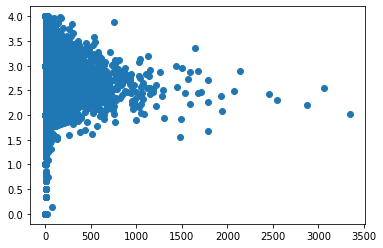

In [68]:
plt.scatter( x = ratings.groupby('user_id').count()['user_rating'], y = ratings.groupby('user_id')['user_rating'].mean())

Text(0.5, 0, 'Average ratings')

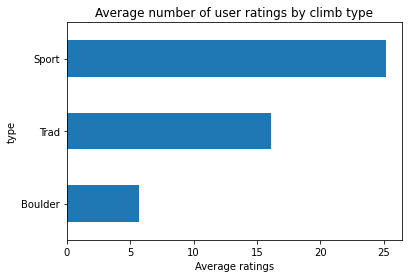

In [67]:
routes.groupby('type')['votes'].mean().sort_values(ascending = True).plot.barh()
plt.title('Average number of user ratings by climb type')
plt.xlabel('Average ratings')

In [85]:
routes[routes['votes'] > 50].sort_values('score', ascending = False)[['route_name','type', 'pitches','score','votes','state']].head(10)

,route_name,type,pitches,score,votes,state
74268,Spectreman,Trad,1,4.0,133,Wyoming
25425,Bullet the Blue Sky,Sport,1,4.0,79,Colorado
13170,Psychatomic,Sport,1,4.0,92,Colorado
56510,Sinestra,Trad,1,4.0,199,Utah
21561,The Scenic Cruise,Trad,13,4.0,224,Colorado
18342,Medicine Man,Trad,4,4.0,68,Colorado
25999,Wunsch's Dihedral,Trad,4,4.0,178,Colorado
2577,Gracious Grant,Sport,1,4.0,53,Arkansas
69466,Leave it to Jesus,Trad,1,4.0,58,West Virginia
7286,Death and Transfiguration,Trad,1,4.0,93,Colorado


In [109]:
boulder_grades = pd.read_csv('./data/boulder_grades.csv')
climb_grades = pd.read_csv('./data/climb_grades.csv')
    
    
grade_dict = {v:k for k,v in climb_grades.to_dict()['grade'].items()}
#grade_dict.update({v:k for k,v in climb_grades.to_dict()['grade'].items()})

In [107]:
ratings[ratings['type'] == 'Sport']['grade'].value_counts()

5.10a    63768
5.9      57940
5.8      50863
5.10b    46146
5.11a    40308
         ...  
5.15         1
V10          1
V1           1
V3-4         1
V3           1
Name: grade, Length: 76, dtype: int64

In [117]:
ratings[(ratings['type'] == 'Sport') & (ratings['grade'].isin(grade_dict.keys()))].groupby(['grade_num'])['score'].mean().reset_index()

KeyError: 'grade_num'

In [129]:
ratings[ratings['grade_numeric']==76]

,user_id,route_id,user_rating,route_name,type,area_id,grade,height,pitches,score,votes,description,grade_numeric,state,area_name
1111739,106603878,116194036,1,B. Sears - Closed Project,Sport,105827602,5.15d,65,1,1.0,1,"Closed Project on the face right of ""American Nightmare"".",76,Wyoming,Fairfield Central
1111785,200158755,116194014,4,Diluted Limelight - Project,Sport,105827602,5.15d,50,1,2.5,2,Project/roof. Obvious.,76,Wyoming,Fairfield Central
1111786,106603878,116194014,1,Diluted Limelight - Project,Sport,105827602,5.15d,50,1,2.5,2,Project/roof. Obvious.,76,Wyoming,Fairfield Central


In [130]:
ratings[ratings['grade_numeric']!=76].groupby(['grade_numeric'])['score'].mean().sort_values().head(100)

grade_numeric
0     1.731102
1     1.923614
2     2.068366
4     2.110072
8     2.228381
        ...   
58    3.491066
64    3.547059
68    3.600000
61    3.622785
66    3.871429
Name: score, Length: 71, dtype: float64

Text(0.5, 0, 'grade')

<Figure size 720x720 with 0 Axes>

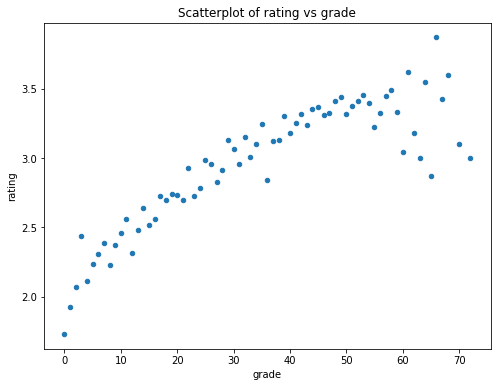

In [146]:
plt.figure(figsize = (10,10))
ratings[ratings['grade_numeric']!=76].groupby(['grade_numeric'])['score'].mean().reset_index().plot(kind = 'scatter', x = 'grade_numeric', y = 'score',  figsize = (8,6))

plt.title('Scatterplot of rating vs grade')
plt.ylabel('rating')
plt.xlabel('grade')




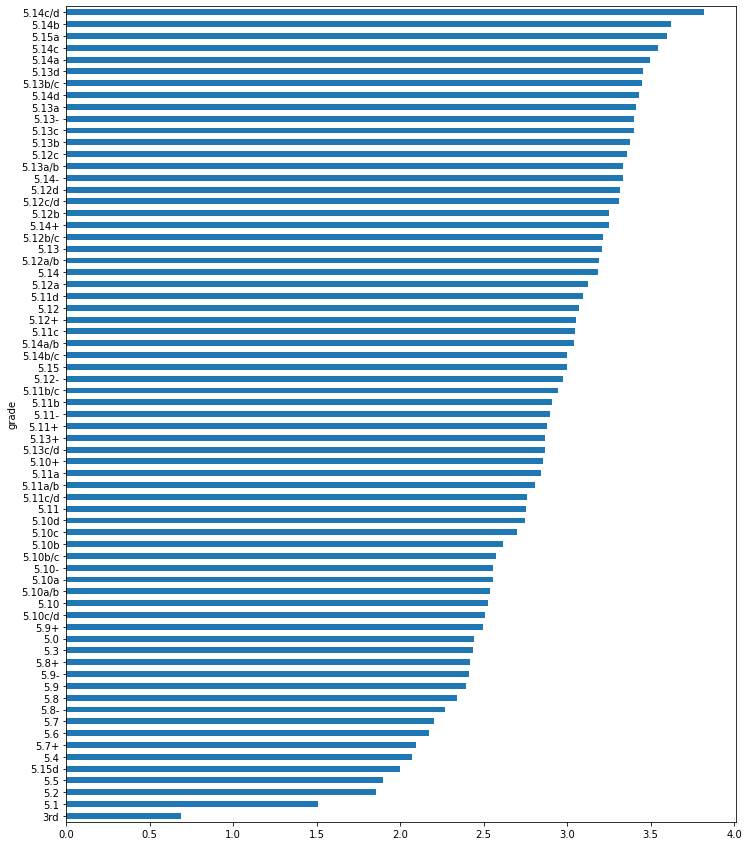

In [124]:
plt.figure(figsize = (12,15))
ratings[(ratings['type'] == 'Sport') & (ratings['grade'].isin(grade_dict.keys()))].groupby(['grade'])['score'].mean().sort_values().plot.barh()

In [ ]:
ratings['user_rating'].value_counts(normalize=True)

In [ ]:
routes['score'].hist(bins = 10, grid = False, density = 1)

In [ ]:
routes['pitches'].hist(bins = 20, grid = False)

In [ ]:
routes['pitches'].value_counts().sort_values('index', ascending = False)

In [ ]:
routes.info()

In [ ]:
areas.info()

In [ ]:
ratings.info()

In [ ]:
routes['route_id'].value_counts()

In [ ]:
ratings.head()

In [ ]:
len(routes['route_id'].unique()) 

In [ ]:
ratings.groupby('route_id')['user_rating'].mean().sort_values(ascending = False)

In [ ]:
ratings[ratings['user_id'] == 10232]

In [ ]:
ratings.groupby('user_id')['user_id'].count().sort_values()

In [ ]:
from surprise import Reader, Dataset

In [ ]:
ratings_10 = ratings[ratings.groupby('user_id')['user_id'].transform('size') >= 50]

In [ ]:
(ratings_10['user_id'].value_counts() > 10)

In [ ]:
ratings_10['user_id'].value_counts()

# Modeling

In [43]:
ratings[ratings['user_id'] == 200503731].shape

(34, 15)

In [89]:
sum(ratings['route_id'].value_counts() >0)

75211

In [101]:

ratings2 = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts()>=10].index)]

In [71]:
ratings['route_id'].value_counts()

105748490    1839
105750106    1343
105717367    1143
105789060    1113
105717364    1094
             ... 
119899537       1
119801249       1
118775902       1
108521519       1
111241171       1
Name: route_id, Length: 75211, dtype: int64

In [ ]:
ratings['route_id'].value_counts()

In [77]:
ratings2.head()

AttributeError: 'tuple' object has no attribute 'head'

In [103]:
ratings2['route_id'].value_counts()>=10

105748490    True
105750106    True
105717367    True
105717364    True
105748657    True
             ... 
110991250    True
107130143    True
117622546    True
106357015    True
112120559    True
Name: route_id, Length: 19723, dtype: bool

In [102]:
ratings2 = ratings2[ratings2['route_id'].isin(ratings2['route_id'].value_counts()[ratings2['route_id'].value_counts()>=10].index)]

In [ ]:
ratings2[]

In [72]:
ratings2 = ratings2[ratings2['route_id'].isin(ratings2['route_id'].value_counts()[ratings2['route_id'].value_counts()>30].index)]




TypeError: tuple indices must be integers or slices, not str

In [104]:
from surprise import SVD, KNNBasic,KNNWithMeans, SVDpp, NMF, BaselineOnly
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split, GridSearchCV
df = ratings2[['user_id', 'route_id', 'user_rating']]
reader = Reader(rating_scale = (0,4))
data = Dataset.load_from_df(df, reader = reader)


In [ ]:
if False:
    trainset, testset = train_test_split(data, test_size=.25)

    baseline = BaselineOnly()
    svd = SVD()
    svdpp = SVDpp()
    knn = KNNBasic()
    knnwithmeans = KNNWithMeans()
    nmf = NMF()

    for  name, algo in [('Baseline', baseline), ('SVD', svd), ('KNNBasic',knn), 
                 ('KNNWithMeans',knnwithmeans), ('NMF',nmf)]:

        algo.fit(trainset)
        predictions = algo.test(testset)


        print(f'{name}:')
        accuracy.rmse(predictions)

Gridsearching

In [84]:
ratings[ratings['user_id'].value_counts() ==1]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [82]:
trainset, testset = train_test_split(data, test_size=.25)

In [109]:
svd = SVD(n_factors=10)
svd.fit(trainset)
predictions = svd.test(testset)

accuracy.rmse(predictions)

RMSE: 0.6489


0.6489095736915519

In [22]:
svd_param_grid = { 'n_factors' : [5, 10, 25, 50, 100, 150, 200],
                  'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

In [ ]:
svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1, joblib_verbose= 5)
svd_gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.6min


In [20]:
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

NameError: name 'svd_gs' is not defined

In [106]:
full_trainset = data.build_full_trainset()

In [107]:
svd = SVD()
svd.fit(full_trainset)

In [108]:
pickle.dump(svd, open('./pickle/svd.pkl', 'wb'))

In [ ]:
from surprise import KNNBaseline
sim_options = {'name': 'pearson_baseline', 'user_based': False}
knn = KNNBaseline(sim_options = sim_options)
knn.fit(full_trainset)

In [ ]:
pickle.dump(knn, open('./pickle/knn.pkl', 'wb'), protocol=4)

In [ ]:
pd.DataFrame([[1, 3, 0, 4, 2], [1, '?', 1, 4, 2], [4, 2, 0, 4, 1], ['?', '?', 2, '?', '?'], [0,0,1,'?',4]], columns = [f'Route {i}' for i in range(1,6)], 
            index = [f'User {i}' for i in range(1,6)])

In [ ]:
if False:
    predictions = svd.test(full_trainset.build_testset())
    test = pd.DataFrame(predictions)
    test = test.rename(columns={'uid':'user_id', 'iid': 'route_id', 
                                'r_ui':'actual', 'est':'prediction'})

    cf_model = test.pivot_table(index='user_id', 
                                columns='route_id', values='prediction').fillna(0)

    def get_users_predictions(user_id, n,model):
        recommended_items = pd.DataFrame(model.loc[user_id])
        recommended_items.columns = ["predicted_rating"]
        recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
        #recommended_items = recommended_items
        return recommended_items.index.tolist(),recommended_items['predicted_rating'].tolist()

    def get_recs(model, k):
        recs = []
        rats = []
        for user in model.index:
            cf_predictions, cf_ratings = get_users_predictions(user, k, model)
            recs.append(cf_predictions)
            rats.append(cf_ratings)
        return recs, rats    

    # Top-10 recommendations for each user
    k = 10
    recs,rats  = get_recs(cf_model, k)
    preds = pd.DataFrame(index=cf_model.index)


In [ ]:
def get_predictions(user_id):
    preds = []
    for route in routes['route_id'].unique():
        preds.append((route,svd.predict(user_id, route).est))
    return  zip(*sorted(preds,key = lambda x: x[1],reverse = True))


def get_top_n(user_id, n= 10, area_ids = [], climb_types = [], min_climb_grade = 0, max_climb_grade = 71, min_boulder_grade = 0, max_boulder_grade = 71, pitches = 1, ignore_completed = True):
    preds = pd.DataFrame(list(zip(*get_predictions(user_id))), columns = ['route_id', 'prediction'])

    
    user_preds = routes.merge(preds, on = 'route_id')
    
    if ignore_completed:
        already_rated = ratings[ratings['user_id'] == user_id]['route_id'].values
        user_preds = user_preds[~user_preds['route_id'].isin(already_rated)]

    if climb_types == []:
        climb_types = ['Boulder', 'Sport', 'Trad']

    boulder_mask = (user_preds['type'] == 'Boulder') & (user_preds['grade_numeric'].isin(range(min_boulder_grade, max_boulder_grade+1))) if 'Boulder' in climb_types else False
    sport_mask = (user_preds['type'] == 'Sport') & (user_preds['grade_numeric'].isin(range(min_climb_grade, max_climb_grade+1))) if 'Sport' in climb_types else False
    trad_mask = (user_preds['type'] == 'Trad') & (user_preds['grade_numeric'].isin(range(min_climb_grade, max_climb_grade+1))) if 'Trad' in climb_types else False                                        
                                                    
    if area_ids == []: 
        area_mask = True                                        
       # return user_preds[(user_preds['type'].isin(climb_types)) & (user_preds['grade_numeric'].isin(range(min_grade, max_grade+1))) & (user_preds['pitches'].isin(list(range(pitches, 100 if pitches != 1 else 2))))].sort_values('prediction', ascending = False).head(n).drop(columns = ['description', 'star_ratings'])
    else:
        subareas = functools.reduce(operator.iconcat, [area_tree.get_children(area_id) for area_id in area_ids], [])
        area_mask = user_preds['area_id'].isin(subareas)
    
    pitch_mask = (user_preds['pitches'].isin(list(range(pitches,100 if pitches != 1 else 2))))
    mask = (boulder_mask | sport_mask | trad_mask) & area_mask & pitch_mask                                            
                                                  
    return user_preds[mask].sort_values('prediction', ascending = False).head(n).drop(columns = ['description', 'star_ratings'])




In [ ]:
def get_similar_users(user_id):
    pass

def get_similar_climbs(route_id):
    
    route_inner_id = knn.trainset.to_inner_iid(route_id)
    route_neighbors = knn.get_neighbors(route_inner_id, k=10)
    route_neighbors = (knn.trainset.to_raw_iid(inner_id)
                       for inner_id in route_neighbors)
    
    return routes[routes['route_id'].isin(route_neighbors)].drop(columns = ['star_ratings', 'description'])

In [ ]:
routes.shape

In [ ]:
get_top_n(user_id = 200503731, climb_types = ['Sport'], area_ids = [], n = 10, ignore_completed = True).to_csv('./streamlit/test_rec.csv', index = False)

In [ ]:
ratings[ratings['user_id'] == 200410792]

In [ ]:
ratings[ratings['user_id'] == 200503731]['route_id'].values

In [ ]:
get_top_n(200410792, area_id = 119375710, n = 40, climb_types = [ 'Sport'])

In [ ]:
get_top_n_type(200503731, n= 10, climb_types = ['Sport'])

In [ ]:
routes[routes['route_id'].isin(top_routes[:10])]  

In [ ]:
full_trainset = data.build_full_trainset()

In [ ]:
svd_full = SVD()
svd_full.fit(full_trainset)

In [ ]:
svd.predict(200760174, 106952812)

In [ ]:
def get_top_n(uid, predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
anti_testset = trainset.build_anti_testset()
predictions = svd.test(anti_testset)

In [ ]:
predictions

In [ ]:
anti_testset = trainset.build_anti_testset()
predictions = svd.test(anti_testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

In [ ]:

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
#data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

In [ ]:
algo.predict(200503731, 105748813)

In [ ]:
ratings.groupby('route_id')['rating'].count().mean()

In [ ]:
ratings['rating_counts'] = pd.DataFrame(ratings.groupby('route_id')['rating'].count())

In [ ]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings['rating'].hist(bins=50)

In [ ]:
type('asdf')

In [ ]:
count = 0
for i, row in routes.iterrows():
    if type(row.description) == str:
        if 'zugzwang' in (row.description.lower()):
            count +=1
            print(row.description)
count            

In [ ]:
sns.distplot(ratings.groupby('route_id')['rating'].count())

In [ ]:
pivot = pd.pivot_table(ratings, index='user_id', columns='route_id', values='rating')

In [ ]:
pivot.head()

In [ ]:
from scipy import sparse

In [ ]:
sparse_pivot = sparse.csr_matrix(pivot.fillna(0))
print(sparse_pivot)

In [ ]:
sparse_pivot.shape

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity


In [ ]:
dists = pairwise_distances(sparse_pivot, metric='cosine')
# dists = cosine_distances(sparse_pivot)                         # Identical but more concise

dists

In [ ]:
similarities = cosine_similarity(sparse_pivot)


In [ ]:
np.all(np.isclose((1.0 - dists), similarities))


In [ ]:
recommender_df = pd.DataFrame(dists, 
                              columns=pivot.index, 
                              index=pivot.index)
recommender_df.head()

In [ ]:
route_ratings.user_id.value_counts()[route_ratings.user_id.value_counts() > 25]

In [ ]:
titles = [110596403,200236355]

for title in titles:
    print(title)
    print('Average rating', pivot.loc[title, :].mean())
    print('Number of ratings', pivot.T[title].count())
    print('')
    print('10 closest movies')
    print(recommender_df[title].sort_values()[1:11])
    print('')

In [ ]:
(route_ratings['user_id'] == 12988).sum()

In [ ]:
route_ratings[route_ratings['user_id'] == 112082211]

In [ ]:
areas

In [ ]:
areas.id.values

In [ ]:
areas.parent_id = areas.parent_id.fillna(0).astype(int)

In [ ]:
area_dict

In [ ]:
area_dict[119622035]

In [ ]:
import math
for k,v in area_dict.items():
    if area_dict[k]['parent']:
        area_dict[k]['children'].append(k)

In [ ]:
for k,v in area_dict.items():
    print(k,v)

In [ ]:
max_depth(105708957)

In [ ]:
get_parent_chain_names(105880441)

In [ ]:
ratings[ratings['user_id'] == 200410792]